In [32]:
import os
import matplotlib.pyplot as plt 
import numpy as np
import sys
import warnings
sys.path.append('../')
from spectral_extraction.spectra_2d import spectra_2d
from spectral_extraction.ploting import plot2d_spectra
from spectral_extraction.fitting import make_fit,paralel_fit
from spectral_extraction.spectra_extraction_results import spectral_extraction_results_handler
from spectral_extraction.utils import guess_picks_image,find_signal
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import astropy
# astropy.__version__

In [4]:
# from astropy.io import fits 
# plt.imshow(data/np.nanmax(data,axis=0),aspect="auto",vmin=0,vmax=1)

In [33]:
image_path ="HE0230-2130_A2B_VIS_COR.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J1036-8544_MAPPED_SCI_MOS.fits"#"J0030-3358_MAPPED_SCI_MOS.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J0030-3358_MAPPED_SCI_MOS.fits"#"J1036-8544_MAPPED_SCI_MOS.fits"#"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits"),"J0030-3358_MAPPED_SCI_MOS.fits" #"
Image2d=spectra_2d(image_path,center_cut = 70 ,size_cut=50,verbose=True)

HE0230-2130_A2B_VIS_COR.fits
mad = 0.0
cut center 70 and cut size 50


#### Check the cutout for any case

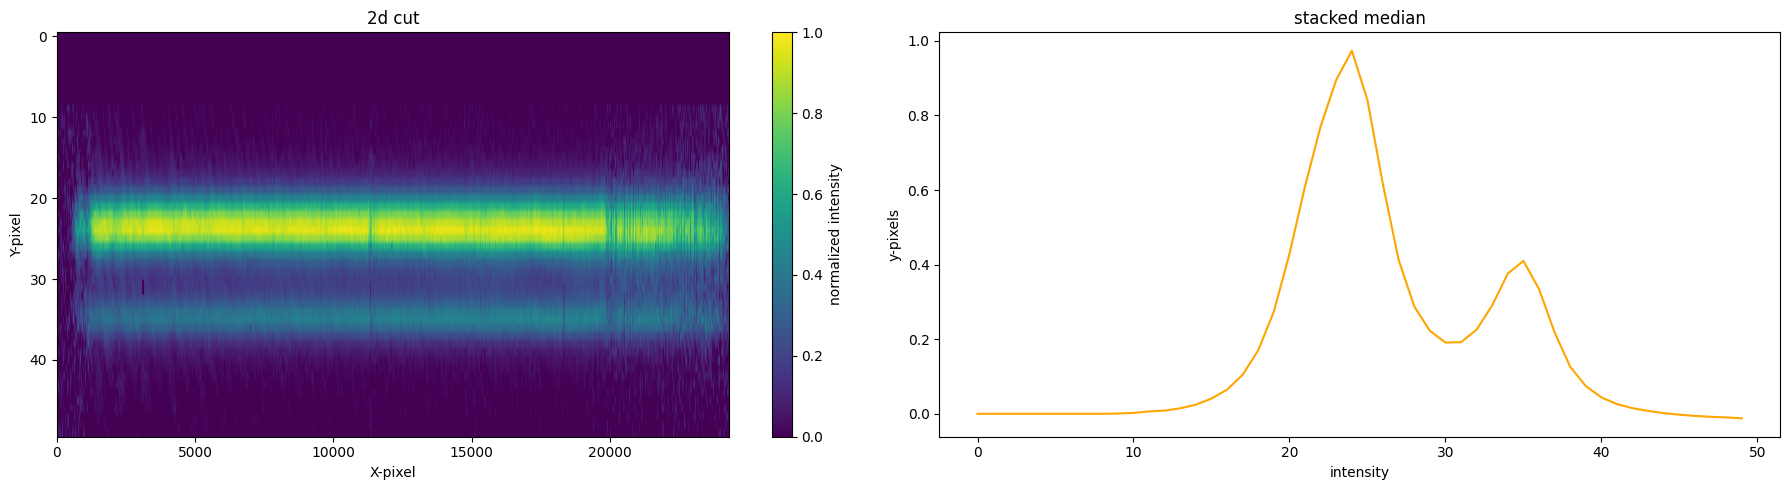

In [34]:
Image2d.plot_cut_out()

## The modeling 

In [35]:
image=Image2d.data2d
picks=np.array([guess_picks_image(i,2) for i in image.T])
guess_center = np.nanmedian(picks)
guess_separation = np.nanmean(picks[:,1:]) - np.nanmedian(picks) 
print(guess_center,guess_separation) # keep the sign in the separation to be consistent with the code

26.0 8.248529714168207


In [19]:
# mask = np.ones_like(image, dtype=bool, order='K', subok=True, shape=None) 
# mask[:,[*i for i in mask_list]] = False

In [20]:
# mask_list = [[0,2],[len(image.T)-1000,len(image.T)-1]]
# for i in mask_list:
#     mask[:,range(*i)] = False

In [21]:
# plt.imshow((image*mask)/(image*mask).max(axis=0),aspect="auto",vmin=0,vmax=1)

#### You can make list with the min and max value for the mask you want to add to our fit, take in consideration look for the sky part of the spectra and add a mask to avoid strange results, the same could be use in the other spectra


In [36]:
mask_list=[[0,2000],[20000,image.shape[1]-1]]
full_result_step_1 = paralel_fit(image,2,initial_center=guess_center,initial_separation=[guess_separation],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=mask_list,\
                          param_value={"sigma_1":2.824245873291126},param_limit={"sigma_1":[2.824245873291126*0.85,2.824245873291126*1.15]},param_fix=None)# at the moment the mask only work in the 

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/24318 [00:00<?, ?it/s]

mean value for value_center_1 if 23.483473217799872


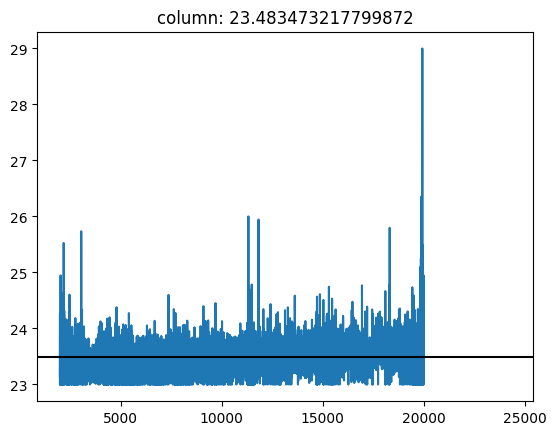

mean value for value_center_2 if 34.45004610592134


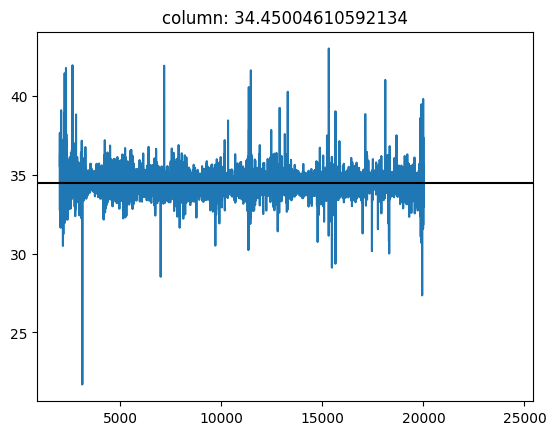

mean value for value_separation_2 if 10.957964377256566


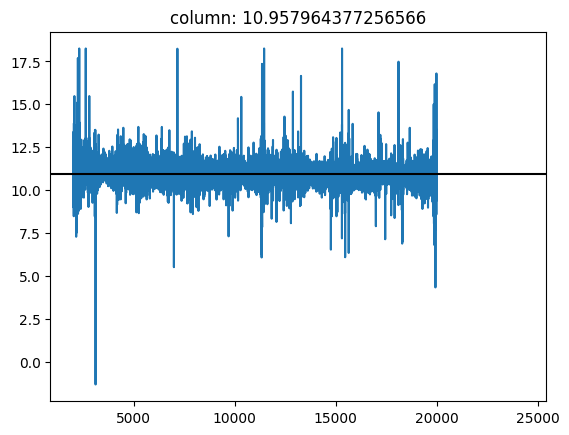

mean value for value_sigma_2 if 2.810910507604966


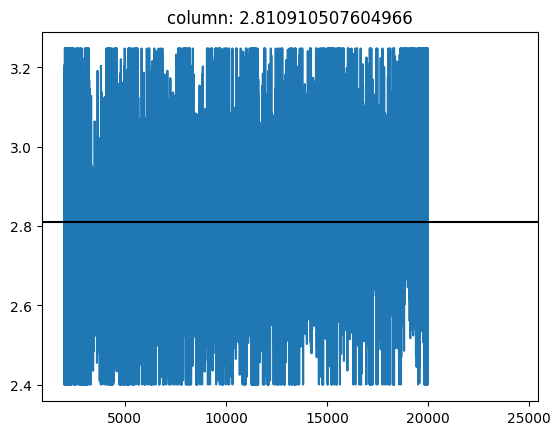

In [37]:
serh_1=spectral_extraction_results_handler(full_result_step_1,conditions={"rsquared":0.8},header=Image2d.header)
median_c1=serh_1.plot_column("value_center_1")
median_c2=serh_1.plot_column("value_center_2")
median_s2=serh_1.plot_column("value_separation_2")
median_sigma2=serh_1.plot_column("value_sigma_2")

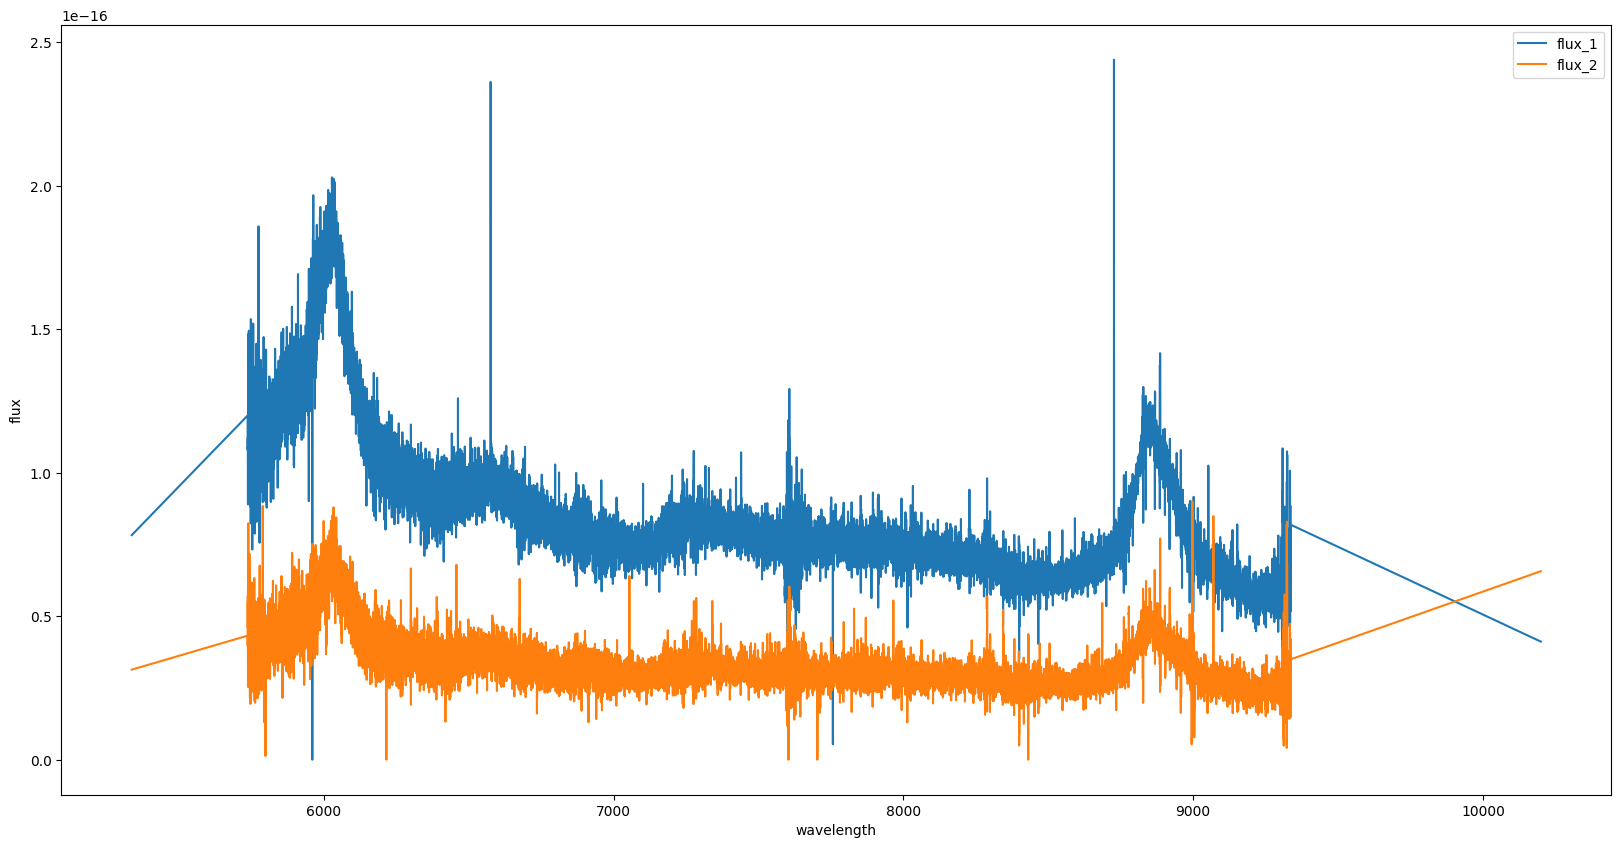

In [38]:
serh_1.plot_spectra()

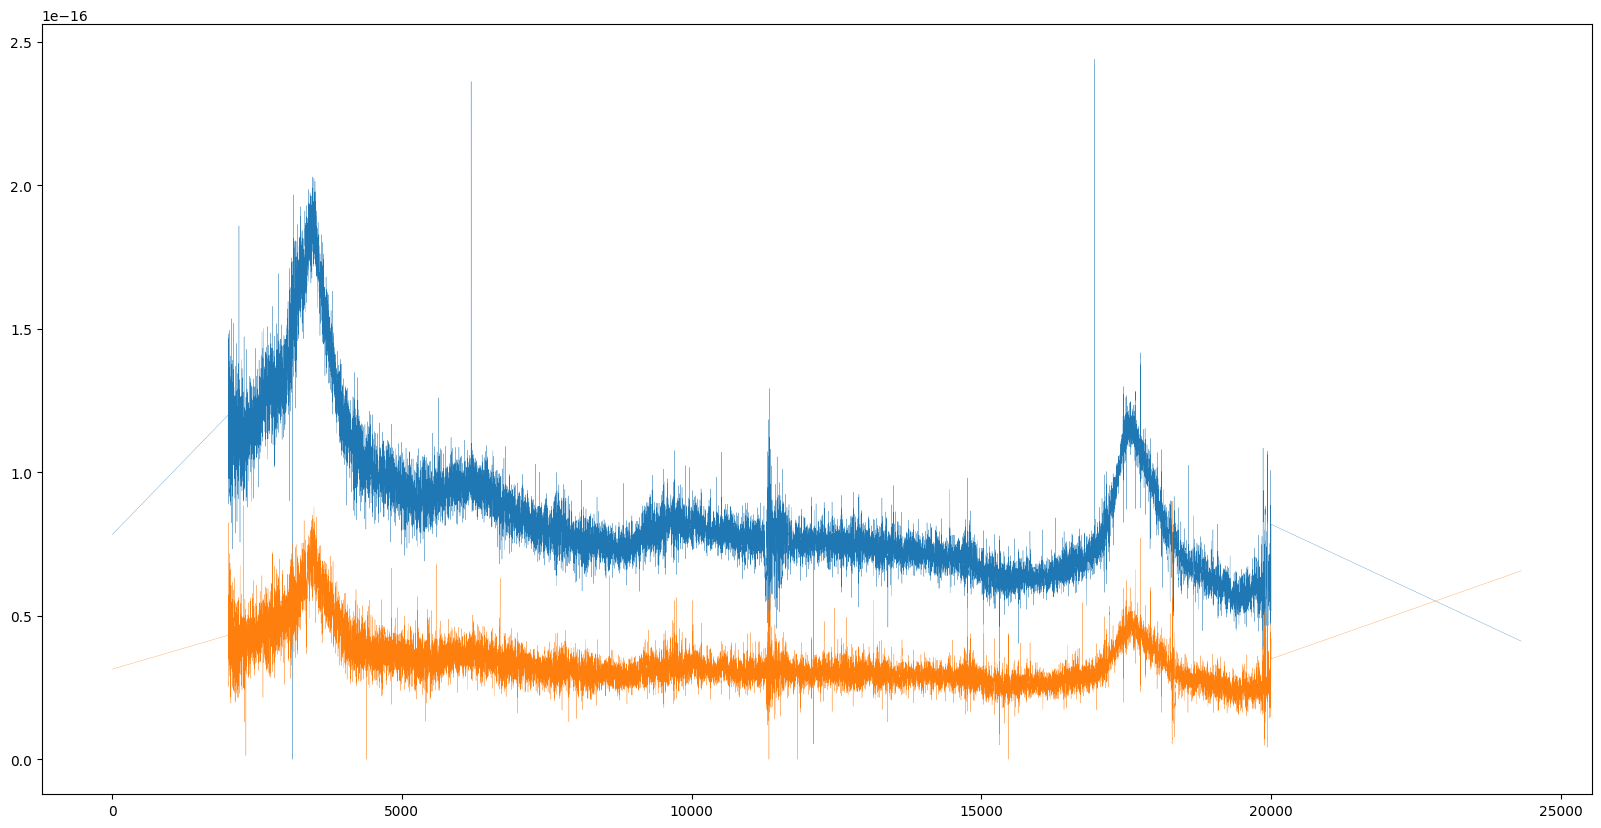

In [39]:
flux_1 = serh_1.spectras1d['flux_1']
flux_2 = serh_1.spectras1d['flux_2']
plt.figure(figsize=(20,10))
plt.plot(flux_1,linewidth=0.2)
plt.plot(flux_2,linewidth=0.2)
#plt.ylim(0,1e-15)

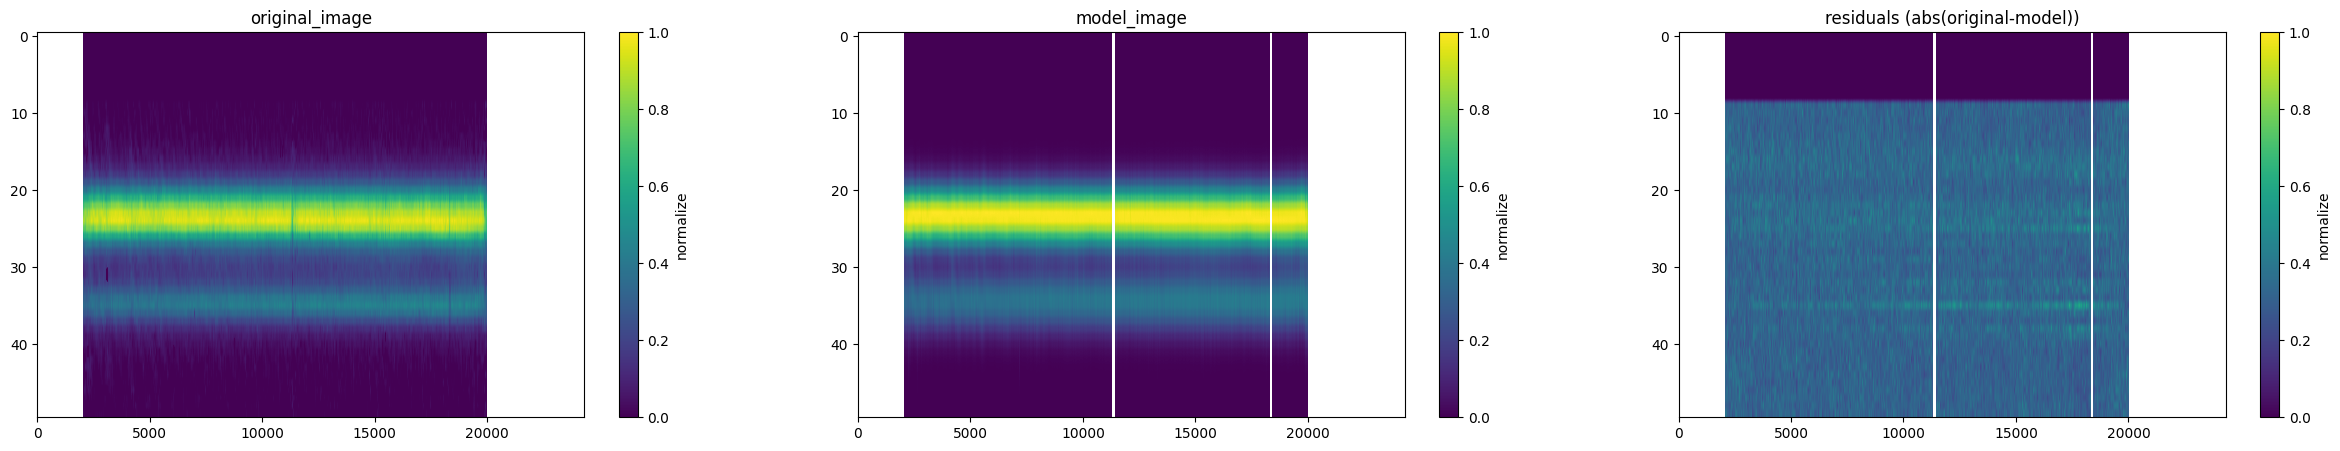

In [40]:
serh_1.plot_2d_image_residuals()

#### Now, as you can see, the spectra don't look good, so a second step is required; in this second step, we can use the median values of the previous step and add some constraints to avoid non logical results, has example change the order of the central position

In [61]:
full_result_2 = paralel_fit(image,2,initial_center=median_c1,initial_separation=[median_s2],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=[],\
                          param_value={"sigma_1":median_sigma2},param_limit={"sigma_1":[median_sigma2*0.85,median_sigma2*1.15]})# 
#results from this are  {"image":image_copy.T,"full_fit":full_fit,"normalize_matrix":normalize_matrix,"num_source":num_source,"distribution":kwargs["distribution"],"mask":mask,"original_image":image}

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/24750 [00:00<?, ?it/s]

### save your results could be a good idea to do that 

In [14]:

with open('my_model_extraction.pickle', 'wb') as handle:
    pickle.dump(full_result_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('my_model_extraction.pickle', 'rb') as handle:
    saved_model = pickle.load(handle)


### pre save

In [102]:
serh_2=spectral_extraction_results_handler(full_result_2,conditions={"min":{"rsquared":0.8},"max":{"flux_1":np.percentile(flux_1,99.9),"flux_2":np.percentile(flux_2,99.9)}},header=Image2d.header) 

mean value for value_center_1 if 19.54685791344022


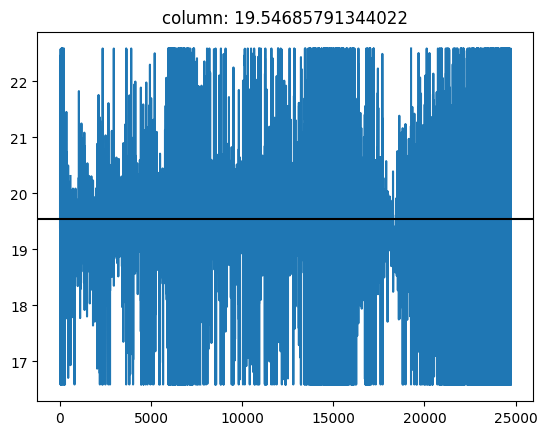

mean value for value_center_2 if 27.281378333802426


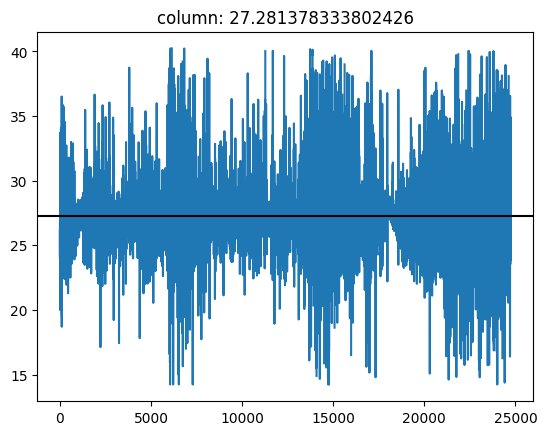

mean value for value_separation_2 if 7.684792073798679


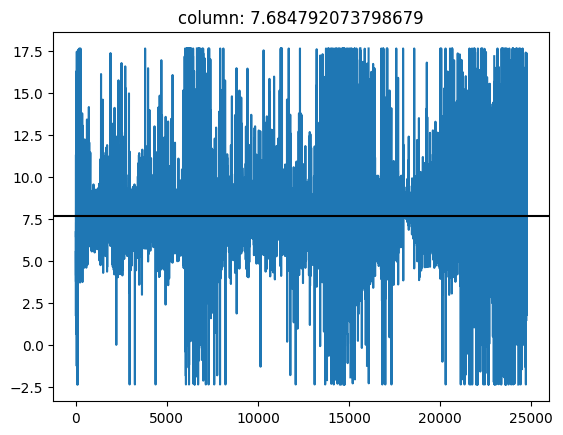

mean value for value_sigma_2 if 2.068024119287922


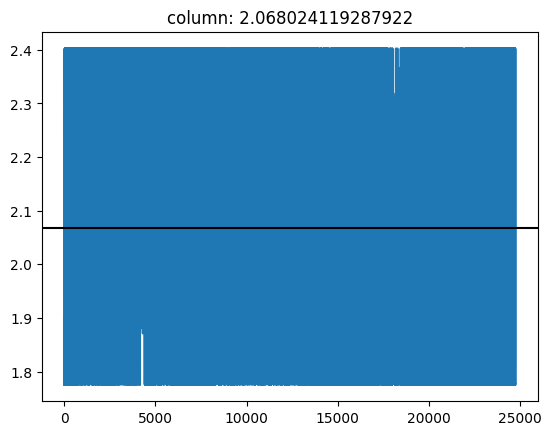

In [103]:
median_c1=serh_2.plot_column("value_center_1")
median_c2=serh_2.plot_column("value_center_2")
median_s2=serh_2.plot_column("value_separation_2")
median_sigma2=serh_2.plot_column("value_sigma_2")

In [39]:
serh_2.plot_2d_image_residuals()

NameError: name 'serh_2' is not defined

#### How to save "spectral_extraction_results_handler" in a efficent way is not done yet but sooner

# NIR

In [34]:
image_path ="HE0230-2130_A2B_NIR_COR.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J1036-8544_MAPPED_SCI_MOS.fits"#"J0030-3358_MAPPED_SCI_MOS.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J0030-3358_MAPPED_SCI_MOS.fits"#"J1036-8544_MAPPED_SCI_MOS.fits"#"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits"),"J0030-3358_MAPPED_SCI_MOS.fits" #"
Image2d=spectra_2d(image_path,center_cut = 55 ,size_cut=40,verbose=True)
#

HE0230-2130_A2B_NIR_COR.fits
mad = 0.0
cut center 55 and cut size 40


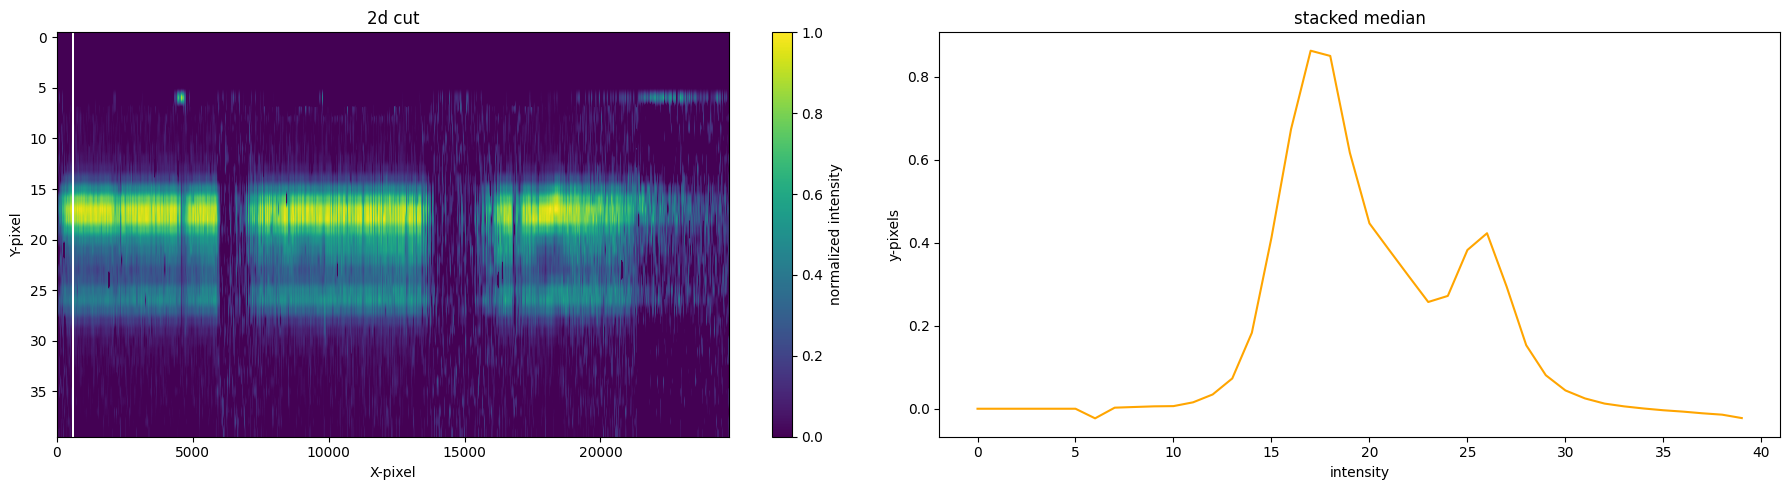

In [35]:
Image2d.plot_cut_out()

In [36]:
image=Image2d.data2d
picks=np.array([guess_picks_image(i,2) for i in image.T])
guess_center = np.nanmedian(picks)
guess_separation = np.nanmean(picks[:,1:]) - np.nanmedian(picks) 
print(guess_center,guess_separation) # keep the sign in the separation to be consistent with the code

19.0 5.112673779502103


In [62]:
mask_list=[[5800,7000],[14000,15500]] #teluric
full_result_step_1 = paralel_fit(image,2,initial_center=guess_center,initial_separation=[guess_separation],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=mask_list,\
                          param_value=None,param_limit=None,param_fix=None)# at the moment the mask only work in the 

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/24750 [00:00<?, ?it/s]

In [63]:
serh_1=spectral_extraction_results_handler(full_result_step_1,conditions={"rsquared":0.7},header=Image2d.header)

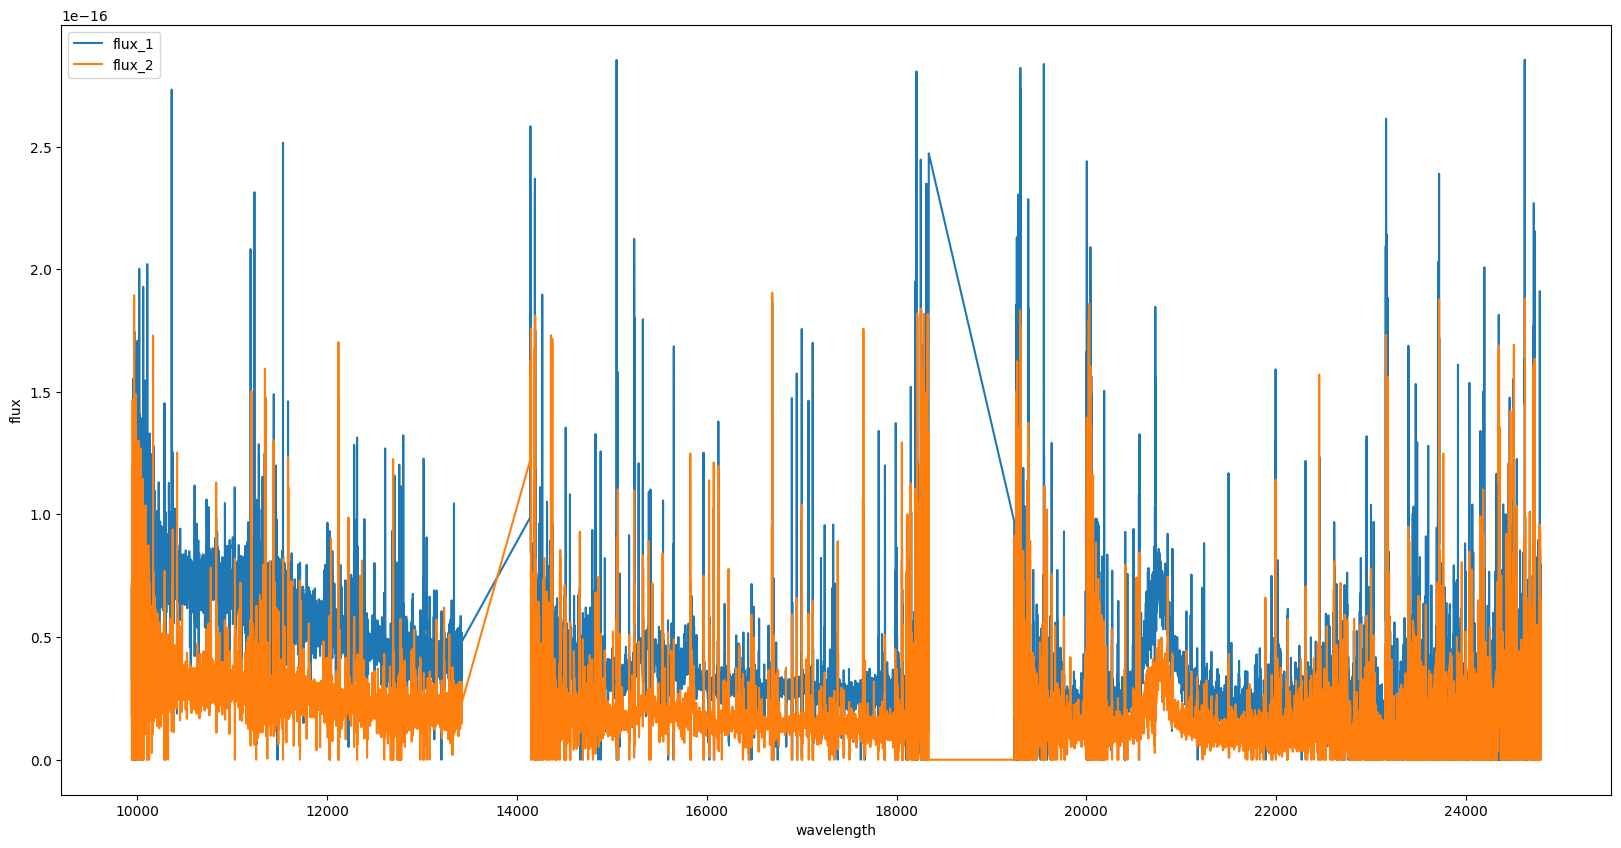

In [67]:
serh_1.plot_spectra()

mean value for value_center_1 if 17.573411322702256


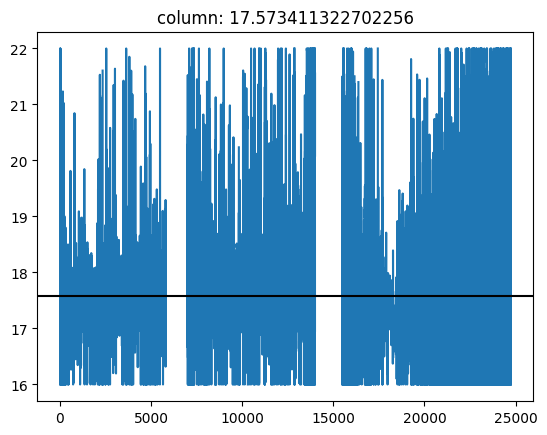

mean value for value_center_2 if 25.273576857508914


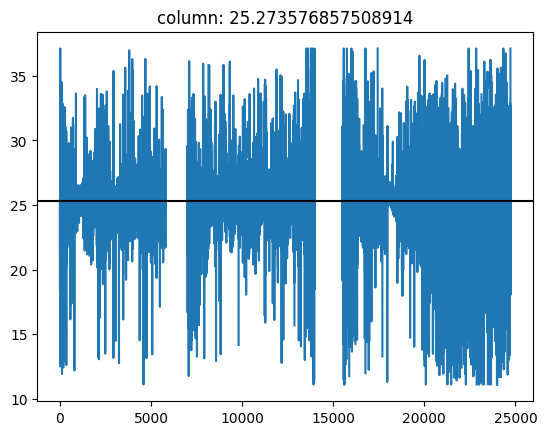

mean value for value_separation_2 if 7.6503712029242505


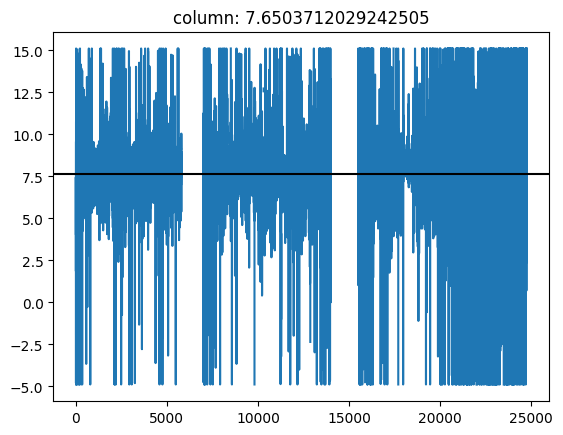

mean value for value_sigma_2 if 2.1190108304573587


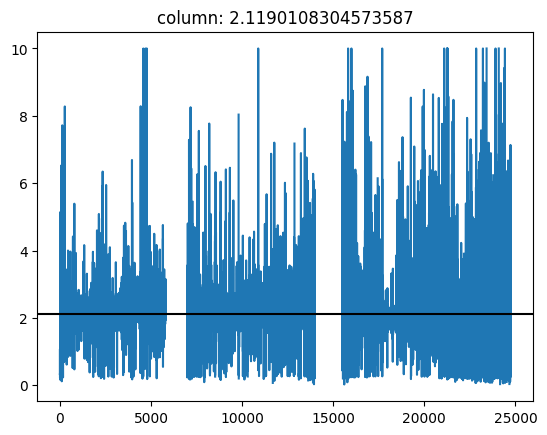

In [68]:
median_c1=serh_1.plot_column("value_center_1")
median_c2=serh_1.plot_column("value_center_2")
median_s2=serh_1.plot_column("value_separation_2")
median_sigma2=serh_1.plot_column("value_sigma_2")

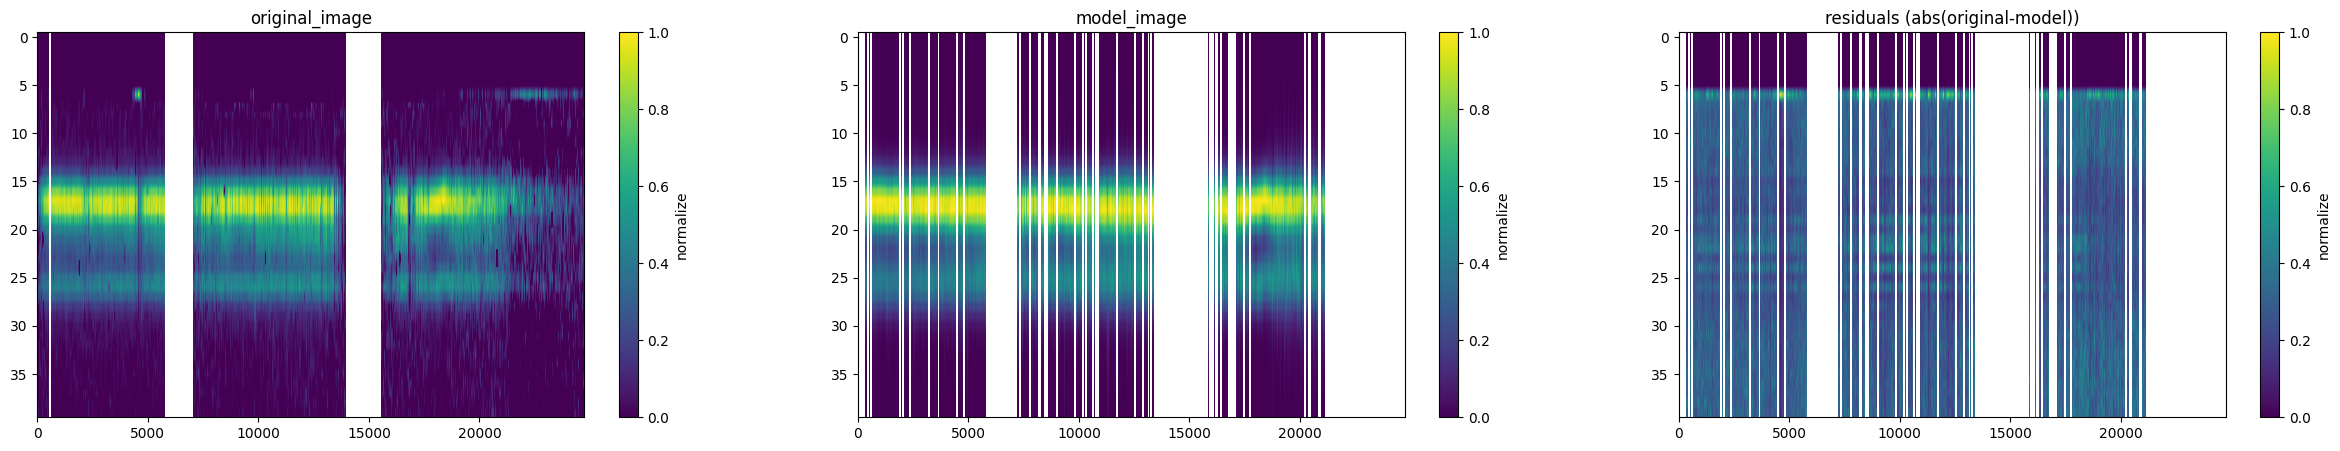

In [69]:
serh_1.plot_2d_image_residuals()

# UVB 

In [81]:
image_path ="HE0230-2130_A2B_UVB.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J1036-8544_MAPPED_SCI_MOS.fits"#"J0030-3358_MAPPED_SCI_MOS.fits"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits")#"J0030-3358_MAPPED_SCI_MOS.fits"#"J1036-8544_MAPPED_SCI_MOS.fits"#"#os.path.join("0230-2130","UVB","HE0230-2130_A2B_UVB.fits"),"J0030-3358_MAPPED_SCI_MOS.fits" #"
Image2d=spectra_2d(image_path,center_cut = None ,size_cut=55,verbose=True)
#

HE0230-2130_A2B_UVB.fits
mad = 0.0
cut center 101 and cut size 55


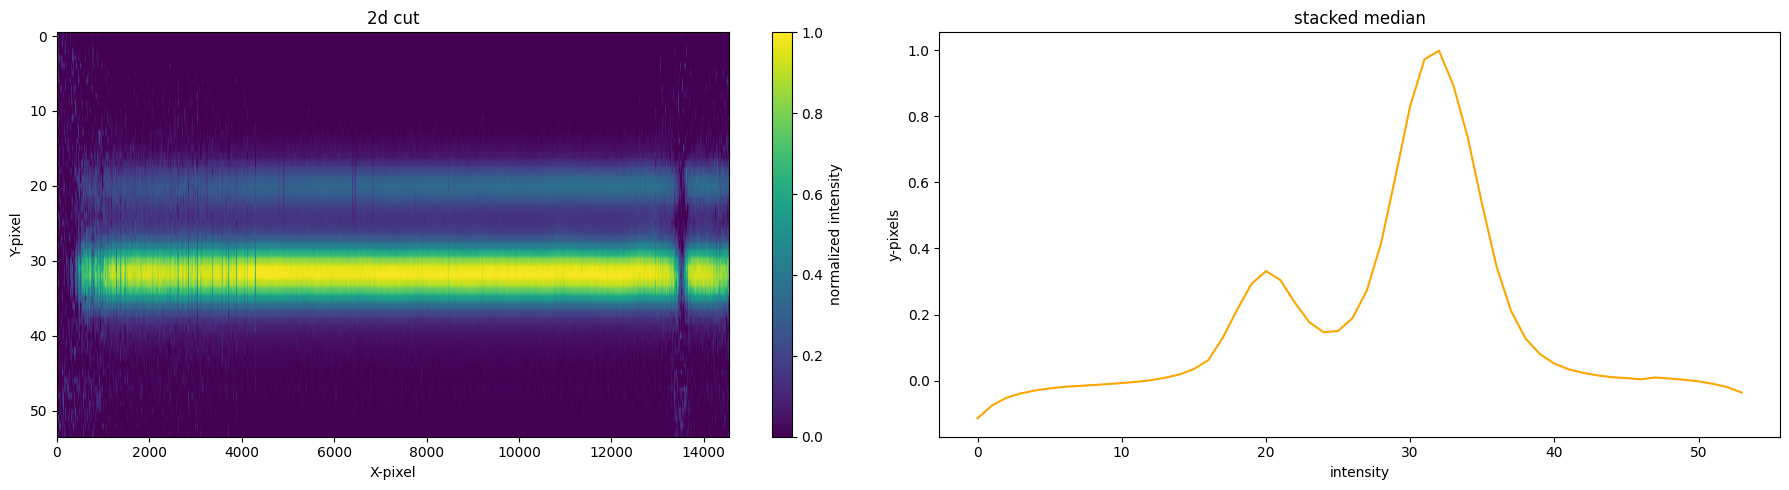

In [77]:
Image2d.plot_cut_out()

In [82]:
image=Image2d.data2d
picks=np.array([guess_picks_image(i,2) for i in image.T])
guess_center = np.nanmedian(picks)
guess_separation = np.nanmean(picks[:,1:]) - np.nanmedian(picks) 
print(guess_center,guess_separation) # keep the sign in the separation to be consistent with the code

31.0 -9.022949017452248


In [83]:
mask_list=[[0,1000]] #teluric
full_result_step_1 = paralel_fit(image,2,initial_center=guess_center,initial_separation=[guess_separation],pixel_limit=[],bound_sigma=[2],distribution="gaussian",mask_list=mask_list,\
                          param_value=None,param_limit=None,param_fix=None)# at the moment the mask only work in the 

The code will be executed in 16 core using 2 sources an a gaussian distribution


DONE:   0%|          | 0/14555 [00:00<?, ?it/s]

In [84]:
serh_1=spectral_extraction_results_handler(full_result_step_1,conditions={"rsquared":0.7},header=Image2d.header)

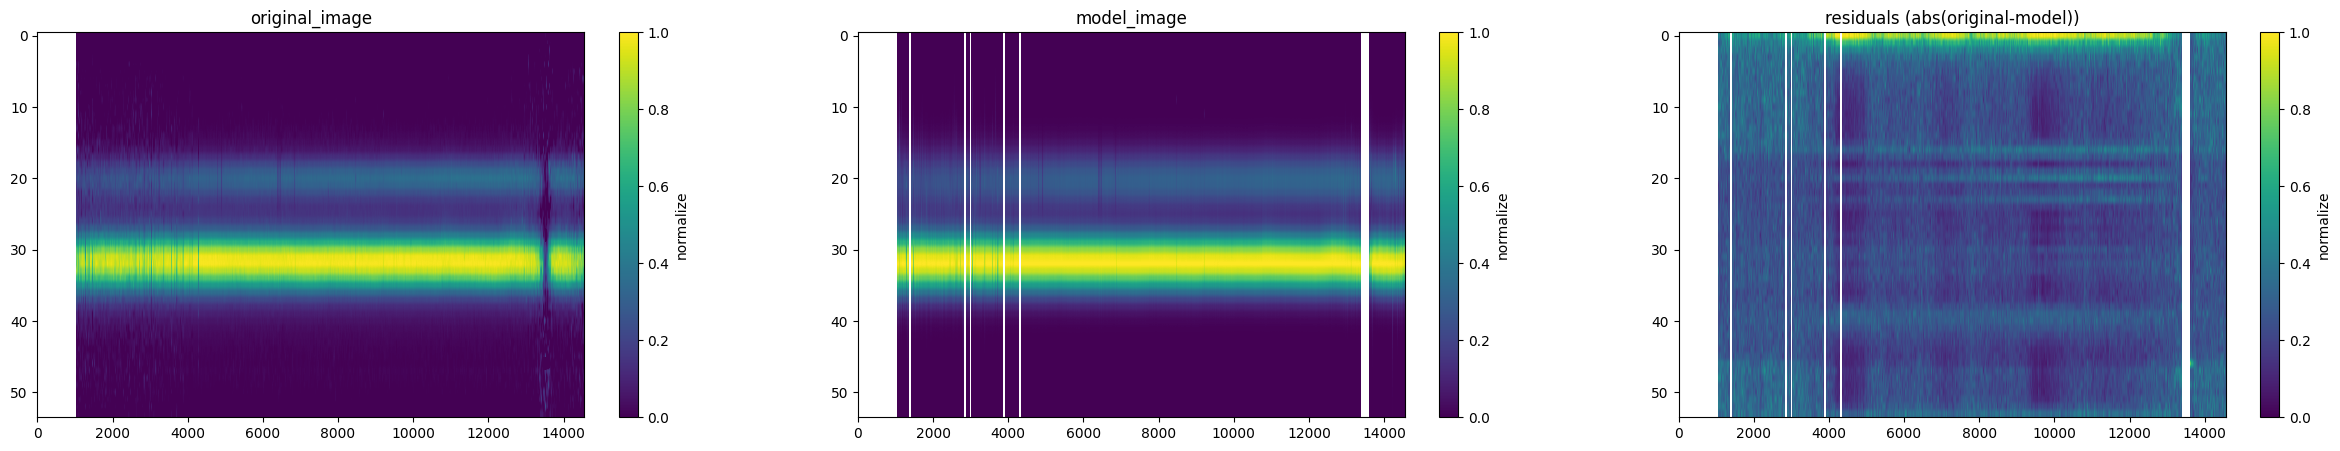

In [85]:
serh_1.plot_2d_image_residuals()

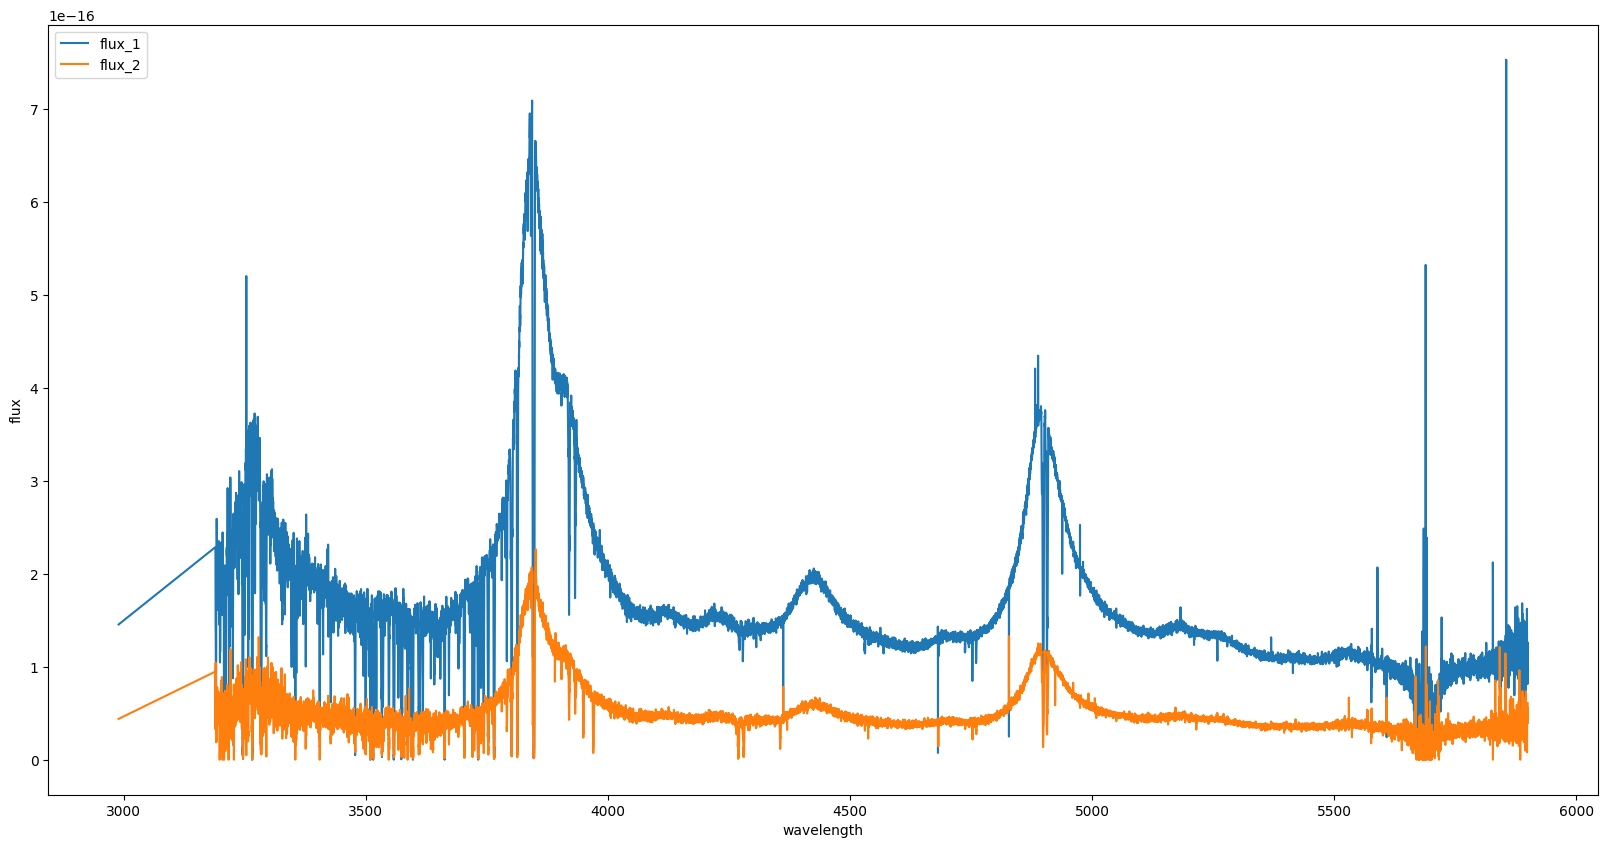

In [86]:
serh_1.plot_spectra()